In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from astropy.modeling.functional_models import Gaussian2D
from astropy.modeling import models, fitting

In [2]:
def BinCenters(bin_edges):
    return (bin_edges[1:]+bin_edges[0:-1])/2.

In [3]:
# We now need to pick a brightness and a level for the random error per pixel
brightness = 10.
sigma_noise = 0.5 

In [4]:
# Let's make an image to hold just one source, with x and y coordinates
Npix = 21
sigma_source = 3.
center = int(Npix/2)
x_coord, y_coord = np.meshgrid(np.arange(Npix), np.arange(Npix))

Notice that `stats.uniform?` will tell us how to use the keywords to get uniform random variables over an interval, and they want is specified as `loc` = left end point, `scale` = number to add to the left endpoint

In [5]:
# Let's constrain the (x,y) position to be toward the center
x0 = stats.uniform.rvs(center-4, 8)
y0 = stats.uniform.rvs(center-4, 8)
#print(x0, y0)

# Make the image
gaussian = Gaussian2D()
signal = gaussian.evaluate(x_coord, y_coord, amplitude=brightness, x_mean=x0, y_mean=y0, 
                           x_stddev=sigma_source, y_stddev=sigma_source, theta=0)
# Make the noise
noise = stats.norm.rvs(loc=0, scale=sigma_noise, size = [Npix, Npix])

# And the sum (the data)
data = signal + noise

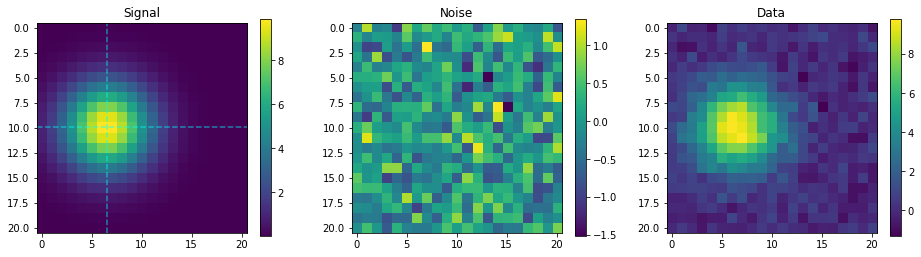

In [6]:
plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(signal)
plt.title('Signal')
plt.axvline(x0,color='cyan',linestyle='--',alpha=0.5)
plt.axhline(y0,color='cyan',linestyle='--',alpha=0.5)
plt.colorbar(shrink=0.8)
plt.subplot(132)
plt.title('Noise')
plt.imshow(noise)
plt.colorbar(shrink=0.8)
plt.subplot(133)
plt.title('Data')
plt.imshow(data)
plt.colorbar(shrink=0.8)
plt.show()

In [7]:
# initialize a fitter
source_fitter = fitting.LevMarLSQFitter()
# initialize a model.  Put initial guess here, which we will assume is at the center of the image.
source_model = models.Gaussian2D(amplitude=data.max(), x_mean=center, y_mean=center, 
                                 x_stddev=sigma_source, y_stddev=sigma_source, theta=0)
# Notice the way that the weights are passed, as 1/standard deviation
fitted_source = source_fitter(source_model, x_coord, y_coord, data, weights=np.ones_like(data)/sigma_noise)
# We want the `cov_x` as the model covariance
print(source_fitter.fit_info['cov_x'])

[[ 1.80153466e-02  3.36909781e-05  8.24349396e-08 -2.78126075e-03
  -2.61497308e-03  2.59868628e-05]
 [ 3.36909781e-05  1.63995330e-03  3.53133799e-06 -2.43103400e-05
  -2.52848315e-08  7.99648525e-06]
 [ 8.24349396e-08  3.53133799e-06  1.52697651e-03 -1.74957421e-07
   1.12325485e-07 -1.87285235e-05]
 [-2.78126075e-03 -2.43103400e-05 -1.74957421e-07  1.68785091e-03
   4.07750542e-08 -1.58344507e-05]
 [-2.61497308e-03 -2.52848315e-08  1.12325485e-07  4.07750542e-08
   1.52704509e-03 -2.85899766e-06]
 [ 2.59868628e-05  7.99648525e-06 -1.87285235e-05 -1.58344507e-05
  -2.85899766e-06  8.25786817e-02]]


In [8]:
source_fitter.fit_info['cov_x']

array([[ 1.80153466e-02,  3.36909781e-05,  8.24349396e-08,
        -2.78126075e-03, -2.61497308e-03,  2.59868628e-05],
       [ 3.36909781e-05,  1.63995330e-03,  3.53133799e-06,
        -2.43103400e-05, -2.52848315e-08,  7.99648525e-06],
       [ 8.24349396e-08,  3.53133799e-06,  1.52697651e-03,
        -1.74957421e-07,  1.12325485e-07, -1.87285235e-05],
       [-2.78126075e-03, -2.43103400e-05, -1.74957421e-07,
         1.68785091e-03,  4.07750542e-08, -1.58344507e-05],
       [-2.61497308e-03, -2.52848315e-08,  1.12325485e-07,
         4.07750542e-08,  1.52704509e-03, -2.85899766e-06],
       [ 2.59868628e-05,  7.99648525e-06, -1.87285235e-05,
        -1.58344507e-05, -2.85899766e-06,  8.25786817e-02]])

In [9]:
fitted_source

<Gaussian2D(amplitude=10.04563891, x_mean=6.5357796, y_mean=9.94690638, x_stddev=3.03116962, y_stddev=2.93315279, theta=0.03386739)>

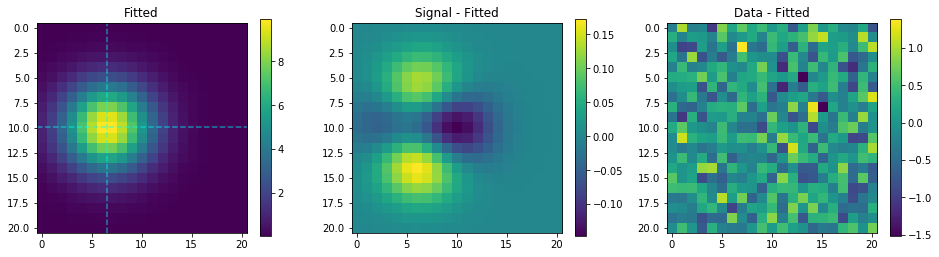

In [10]:
plt.figure(figsize=(16,5))
plt.subplot(131)
plt.title('Fitted')
plt.imshow(fitted_source(x_coord, y_coord))
plt.axvline(x0,color='cyan',linestyle='--',alpha=0.5)
plt.axhline(y0,color='cyan',linestyle='--',alpha=0.5)
plt.colorbar(shrink=0.8)
plt.subplot(132)
plt.title('Signal - Fitted')
plt.imshow(signal - fitted_source(x_coord, y_coord))
plt.colorbar(shrink=0.8)
plt.subplot(133)
plt.title('Data - Fitted')
plt.imshow(data - fitted_source(x_coord, y_coord))
plt.colorbar(shrink=0.8)
plt.show()

Notice that astropy also fit for the x and y width and the rotation angle theta.  Let's now assume that we actually know these exactly and *don't* want to fit for them.  We need to provide a constraint on these parameters, that they are *fixed*.  `astropy.modelling` provides a way to do this: https://docs.astropy.org/en/stable/modeling/parameters.html#parameter-constraints

In [11]:
source_model = models.Gaussian2D(amplitude=data.max(), x_mean=center, y_mean=center, 
                                 x_stddev=sigma_source, y_stddev=sigma_source, theta=0)

source_model.x_stddev.fixed = True
source_model.y_stddev.fixed = True
source_model.theta.fixed = True

# Notice the way that the weights are passed, as 1/standard deviation
fitted_source = source_fitter(source_model, x_coord, y_coord, data, weights=np.ones_like(data)/sigma_noise)
# We want the `cov_x` as the model covariance
print(source_fitter.fit_info['cov_x'])

[[ 8.84557402e-03 -5.61131809e-06 -1.50757540e-09]
 [-5.61131809e-06  1.60575666e-03 -3.49704993e-20]
 [-1.50757540e-09 -3.49704994e-20  1.59772377e-03]]


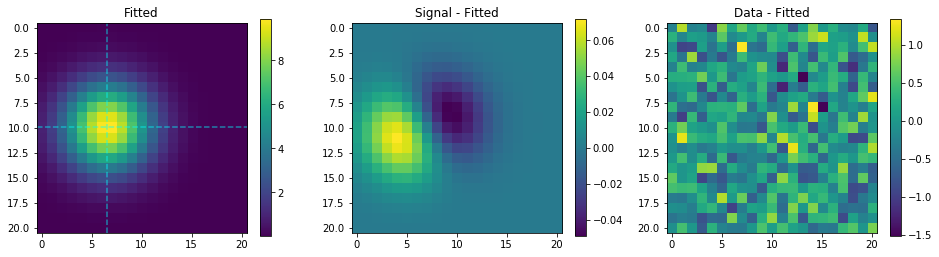

In [12]:
plt.figure(figsize=(16,5))
plt.subplot(131)
plt.title('Fitted')
plt.imshow(fitted_source(x_coord, y_coord))
plt.axvline(x0,color='cyan',linestyle='--',alpha=0.5)
plt.axhline(y0,color='cyan',linestyle='--',alpha=0.5)
plt.colorbar(shrink=0.8)
plt.subplot(132)
plt.title('Signal - Fitted')
plt.imshow(signal - fitted_source(x_coord, y_coord))
plt.colorbar(shrink=0.8)
plt.subplot(133)
plt.title('Data - Fitted')
plt.imshow(data - fitted_source(x_coord, y_coord))
plt.colorbar(shrink=0.8)
plt.show()

In [13]:
source_model.param_names

('amplitude', 'x_mean', 'y_mean', 'x_stddev', 'y_stddev', 'theta')

In [14]:
source_fitter.fit_info.keys()

dict_keys(['nfev', 'fvec', 'fjac', 'ipvt', 'qtf', 'message', 'ierr', 'param_jac', 'param_cov', 'njev', 'cov_x'])

In [15]:
def Cov2Corr(cov):
    norm = np.sqrt(np.diag(cov))
    norm_outer = np.outer(norm, norm)
    corr = cov / norm_outer
    return corr

In [16]:
Cov2Corr(source_fitter.fit_info['cov_x'])

array([[ 1.00000000e+00, -1.48888794e-03, -4.01019215e-07],
       [-1.48888794e-03,  1.00000000e+00, -2.18328846e-17],
       [-4.01019215e-07, -2.18328847e-17,  1.00000000e+00]])